In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn shap joblib fastapi uvicorn


In [ ]:
# cell 0: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_curve, roc_auc_score,
                             average_precision_score, PrecisionRecallDisplay,
                             RocCurveDisplay)
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import shap
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


In [ ]:
# cell 1: simulate a transaction dataset (mixed types)
def simulate_transactions(n=200000, fraud_ratio=0.02, random_state=42):
    np.random.seed(random_state)
    # continuous features
    transaction_amount = np.round(np.exp(np.random.normal(3.0, 1.2, n)), 2)  # skewed
    account_age_days = np.random.exponential(scale=365, size=n).astype(int)  # days since account creation
    avg_amount_30d = np.round(transaction_amount * np.random.uniform(0.5, 1.5, n), 2)
    num_tx_last_24h = np.random.poisson(0.5, n)
    device_distance_km = np.abs(np.random.normal(10, 50, n))  # unusual distances possible

    # categorical features
    merchant_categories = ['grocery', 'electronics', 'travel', 'luxury', 'utilities', 'gaming']
    merchant = np.random.choice(merchant_categories, size=n, p=[0.30,0.20,0.10,0.05,0.25,0.10])
    payment_type = np.random.choice(['card_present', 'card_not_present', 'wallet', 'bank_transfer'], size=n,
                                    p=[0.35, 0.45, 0.1, 0.1])
    country = np.random.choice(['domestic','foreign'], size=n, p=[0.95, 0.05])
    device_type = np.random.choice(['mobile','desktop','tablet'], size=n, p=[0.6, 0.3, 0.1])

    # customer-level risk score (simulated)
    customer_risk_score = np.clip(np.random.normal(0.2, 0.15, n), 0, 1)

    # base fraud probability influenced by suspicious signals
    base_prob = 0.001  # baseline
    prob = (base_prob
            + (transaction_amount > 500).astype(float) * 0.01
            + (payment_type == 'card_not_present').astype(float) * 0.004
            + (country == 'foreign').astype(float) * 0.02
            + (num_tx_last_24h > 5).astype(float) * 0.015
            + (customer_risk_score * 0.05)
            + (device_distance_km > 500).astype(float) * 0.03)

    # scale so that overall fraud ratio ~ fraud_ratio
    prob = prob / prob.mean() * fraud_ratio

    # sample labels
    y = np.random.binomial(1, np.clip(prob, 0, 0.9), size=n)

    df = pd.DataFrame({
        'transaction_amount': transaction_amount,
        'account_age_days': account_age_days,
        'avg_amount_30d': avg_amount_30d,
        'num_tx_last_24h': num_tx_last_24h,
        'device_distance_km': device_distance_km,
        'merchant': merchant,
        'payment_type': payment_type,
        'country': country,
        'device_type': device_type,
        'customer_risk_score': customer_risk_score,
        'is_fraud': y
    })
    return df

df = simulate_transactions(n=150000, fraud_ratio=0.02)
df['is_fraud'].mean()


np.float64(0.02012)

   transaction_amount  account_age_days  avg_amount_30d  num_tx_last_24h  \
0               36.45               235           54.25                1   
1               17.01               607           10.72                0   
2               43.69               417           39.31                0   
3              124.92               162          103.33                2   
4               15.17                17           11.73                0   

   device_distance_km     merchant      payment_type   country device_type  \
0           80.472978      grocery  card_not_present  domestic     desktop   
1           50.641187       luxury  card_not_present  domestic      mobile   
2           39.889421      grocery  card_not_present   foreign     desktop   
3            2.376247  electronics  card_not_present  domestic      tablet   
4            7.211966    utilities      card_present  domestic      mobile   

   customer_risk_score  is_fraud  
0             0.138985         0  
1   

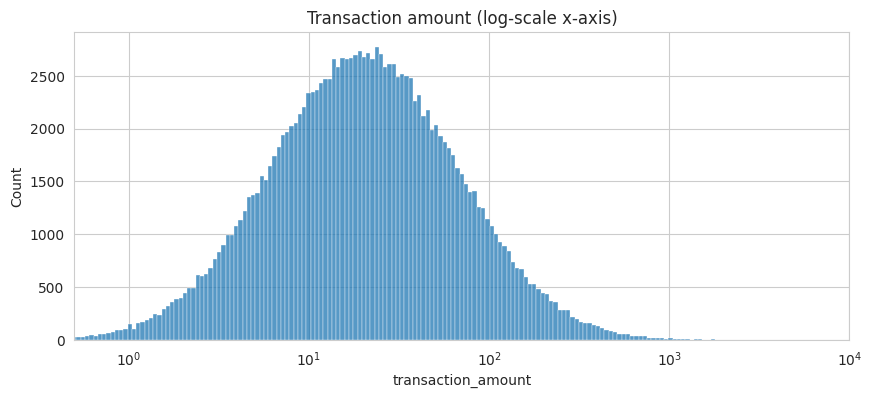

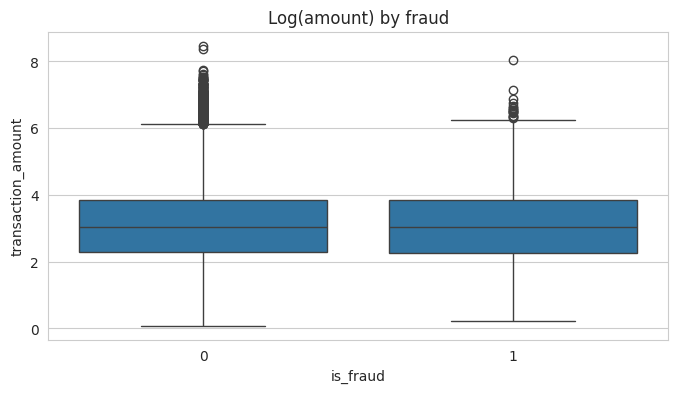


Top fraud rates by merchant:
 merchant
luxury         0.020536
travel         0.020474
electronics    0.020205
grocery        0.020156
utilities      0.019932
Name: is_fraud, dtype: float64

Top fraud rates by payment_type:
 payment_type
card_not_present    0.022825
bank_transfer       0.018703
wallet              0.018615
card_present        0.017471
Name: is_fraud, dtype: float64

Top fraud rates by country:
 country
foreign     0.045931
domestic    0.018772
Name: is_fraud, dtype: float64

Top fraud rates by device_type:
 device_type
desktop    0.021034
mobile     0.019810
tablet     0.019251
Name: is_fraud, dtype: float64


In [ ]:
# cell 2: EDA summary
print(df.head())
print("\nClass balance:")
print(df['is_fraud'].value_counts(normalize=True))

# Amount distribution
plt.figure(figsize=(10,4))
sns.histplot(df['transaction_amount'], bins=200, log_scale=(True, False))
plt.title("Transaction amount (log-scale x-axis)")
plt.xlim(0.5, 10000)
plt.show()

# Fraud vs amount boxplot (log-transform for visualization)
plt.figure(figsize=(8,4))
sns.boxplot(x='is_fraud', y=np.log1p(df['transaction_amount']), data=df)
plt.title("Log(amount) by fraud")
plt.show()

# Categorical fraud rates
cat_cols = ['merchant','payment_type','country','device_type']
for c in cat_cols:
    rates = df.groupby(c)['is_fraud'].mean().sort_values(ascending=False)
    print(f"\nTop fraud rates by {c}:\n", rates.head(5))


In [ ]:
# cell 3: feature engineering
df['log_amount'] = np.log1p(df['transaction_amount'])
df['amount_over_avg30'] = df['transaction_amount'] / (df['avg_amount_30d'] + 1e-6)
df['new_customer'] = (df['account_age_days'] < 30).astype(int)
df['high_freq_24h'] = (df['num_tx_last_24h'] > 3).astype(int)

# choose features
feature_cols = [
    'log_amount', 'amount_over_avg30', 'account_age_days',
    'num_tx_last_24h', 'device_distance_km', 'customer_risk_score',
    'new_customer', 'high_freq_24h', 'merchant', 'payment_type', 'country', 'device_type'
]

X = df[feature_cols].copy()
y = df['is_fraud'].copy()


In [ ]:
# cell 4: split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train fraud rate:", y_train.mean(), "Test fraud rate:", y_test.mean())


Train fraud rate: 0.020116666666666668 Test fraud rate: 0.020133333333333333


In [ ]:
# cell 5: pipeline prep
numeric_features = ['log_amount', 'amount_over_avg30', 'account_age_days',
                    'num_tx_last_24h', 'device_distance_km', 'customer_risk_score',
                    'new_customer', 'high_freq_24h']
categorical_features = ['merchant', 'payment_type', 'country', 'device_type']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  # robust to outliers
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop'
)

In [ ]:
# cell 6: Logistic baseline
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga'))
])
pipe_lr.fit(X_train, y_train)
y_pred_proba = pipe_lr.predict_proba(X_test)[:,1]
print("Logistic ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Logistic PR AUC:", average_precision_score(y_test, y_pred_proba))


Logistic ROC AUC: 0.6698359194700544
Logistic PR AUC: 0.03707423871769561


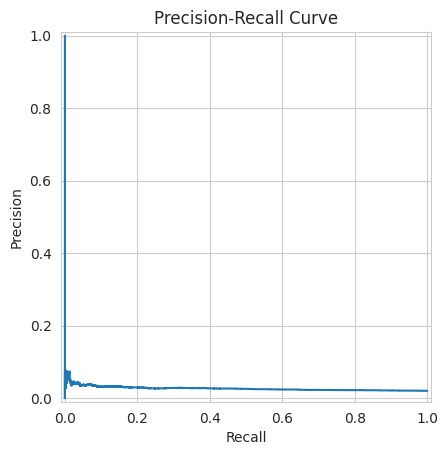

No threshold achieves target precision; you must accept lower precision or improve model.


In [ ]:
# cell 9: precision-recall and threshold selection
probs = y_xgb_proba  # choose your best model
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# plot PR curve
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision-Recall Curve")
plt.show()

# find threshold achieving ~0.8 precision (example)
target_precision = 0.8
# Exclude the last element of precision and recall as there's no corresponding threshold
idx = np.where(precision[:-1] >= target_precision)[0]
if len(idx) > 0:
    chosen_idx = idx[-1]  # max recall at >= target_precision
    chosen_threshold = thresholds[chosen_idx]
    print("Chosen threshold for precision >= {:.2f}: {:.4f}".format(target_precision, chosen_threshold))
    print("At threshold: precision {:.3f}, recall {:.3f}".format(precision[chosen_idx], recall[chosen_idx]))
else:
    print("No threshold achieves target precision; you must accept lower precision or improve model.")

In [ ]:
# cell 7: XGBoost with SMOTE pipeline
# SMOTE requires numerical input, so it must come after one-hot encoding
pipe_xgb = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('clf', xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]))),
])

pipe_xgb.fit(X_train, y_train)
y_xgb_proba = pipe_xgb.predict_proba(X_test)[:, 1]

print("XGBoost ROC AUC:", roc_auc_score(y_test, y_xgb_proba))
print("XGBoost PR AUC:", average_precision_score(y_test, y_xgb_proba))

XGBoost ROC AUC: 0.5672545269032413
XGBoost PR AUC: 0.026646684276455085


num_tx_last_24h                  0.070324
new_customer                     0.069445
country_domestic                 0.068453
payment_type_card_not_present    0.067559
merchant_luxury                  0.063550
payment_type_card_present        0.057600
merchant_gaming                  0.049269
device_type_tablet               0.047791
merchant_electronics             0.045844
merchant_travel                  0.043161
customer_risk_score              0.041527
payment_type_wallet              0.039254
payment_type_bank_transfer       0.039207
device_type_mobile               0.038307
merchant_utilities               0.036823
merchant_grocery                 0.035363
device_type_desktop              0.034193
device_distance_km               0.029611
log_amount                       0.029053
account_age_days                 0.029025
country_foreign                  0.028467
amount_over_avg30                0.025872
high_freq_24h                    0.010300
dtype: float32


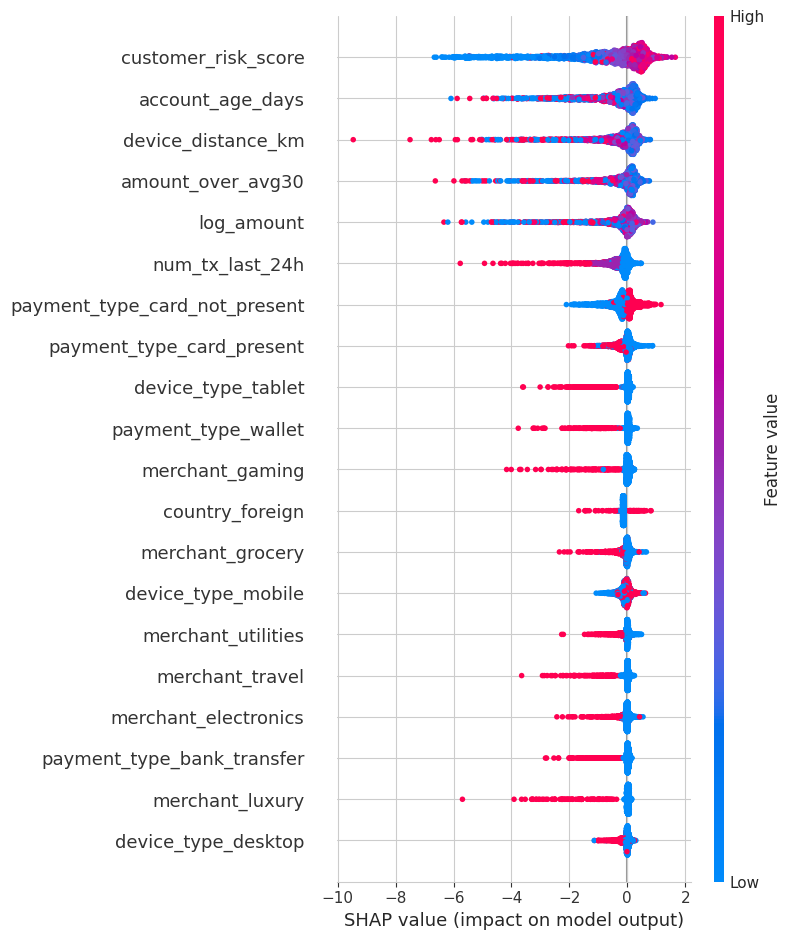

In [ ]:
# cell 10: feature names (after preprocessor)
preprocessor.fit(X_train)
ohe = preprocessor.named_transformers_['cat']['onehot']
ohe_cols = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + ohe_cols

# get trained xgboost booster from pipeline
xgb_model = pipe_xgb.named_steps['clf']
X_test_trans = preprocessor.transform(X_test)

# feature importance
importances = xgb_model.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
print(fi)

# SHAP (can be slow for large datasets)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_trans[:2000])  # sample for speed
shap.summary_plot(shap_values, pd.DataFrame(X_test_trans[:2000], columns=feature_names), show=True)


In [ ]:
# cell 11: save model
model_artifact_path = "fraud_xgb_pipeline.joblib"
joblib.dump(pipe_xgb, model_artifact_path)
print("Saved model to", model_artifact_path)


Saved model to fraud_xgb_pipeline.joblib
